This file intends to solve the following questions:
    - Read in data ('Posts_all.csv')
    - Find the optional number of topics
    - Topic description
    - Save the model
    
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/;
- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
- http://qpleple.com/topic-coherence-to-evaluate-topic-models/

# Import saved data

In [1]:
import sys
import os,glob
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim.test.utils import datapath
from gensim.corpora import Dictionary
from gensim.test.utils import get_tmpfile

# NLTK Stop words
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hellofutrue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
posts_all = pd.read_csv('/Users/hellofutrue/Desktop/Insight/Python/Feb/files/posts_all.csv')

In [3]:
posts_all

,Unnamed: 0,0
0,0,"""Keep changing, connect with everything and co..."
1,1,True Blue.
2,2,#regram of @halfadams thank you for making me ...
3,3,"""Children wake up. Hold your mistake up. Befor..."
4,4,Beautiful day down under.
5,5,Swimmers in swimmers.
6,6,All of the feels. #coachella #coachella2017 #l...
7,7,Home.
8,8,Just a reminder. #regram @the_lane
9,9,"The little mermaid. Video by @halfadams song ""..."


In [4]:
posts_all.columns.values

array(['Unnamed: 0', '0'], dtype=object)

# Data preprocessing

In [5]:
# Convert to list
posts_all = posts_all.rename(index=str, columns={'Unnamed: 0': "unimportant", '0': 'content'})
data = posts_all.content.values.tolist()

In [6]:
# Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
stop_words = stopwords.words('english')
stop_words.extend(['com', 'bio','link','get','go'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


# Find the optional number of topics

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

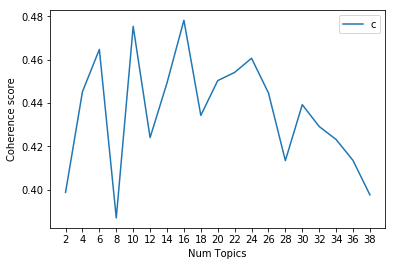

In [21]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.xticks(range(start, limit, step))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('/Users/hellofutrue/Desktop/Insight/Python/Feb/outputs/topiccoherence.png',dpi=300,bbox_inches='tight',transparent = True)
#save before show, otherwise it is a blank image
plt.show()

A good model will generate coherent topics, i.e., topics with high topic coherence scores. Good topics are topics that can be described by a short label, therefore this is what the topic coherence measure should capture.

# Finalized the model topic # = 10

In [22]:
# Build final LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.084*"watch" + 0.080*"let" + 0.061*"real" + 0.054*"full" + 0.039*"dream" + '
  '0.033*"win" + 0.027*"eye" + 0.021*"idea" + 0.021*"run" + 0.017*"believe"'),
 (1,
  '0.059*"new" + 0.058*"time" + 0.039*"movie" + 0.035*"fun" + 0.027*"guy" + '
  '0.023*"play" + 0.023*"start" + 0.022*"keep" + 0.014*"something" + '
  '0.013*"be"'),
 (2,
  '0.049*"say" + 0.043*"want" + 0.028*"set" + 0.027*"live" + 0.025*"fan" + '
  '0.024*"team" + 0.024*"call" + 0.024*"cool" + 0.022*"home" + 0.021*"game"'),
 (3,
  '0.061*"man" + 0.056*"ever" + 0.034*"kid" + 0.029*"may" + 0.026*"build" + '
  '0.026*"baby" + 0.025*"brother" + 0.022*"even" + 0.021*"gym" + 0.021*"boy"'),
 (4,
  '0.045*"work" + 0.038*"come" + 0.025*"today" + 0.018*"tomorrow" + '
  '0.018*"give" + 0.017*"grateful" + 0.017*"need" + 0.016*"week" + '
  '0.015*"everyone" + 0.014*"woman"'),
 (5,
  '0.067*"get" + 0.065*"big" + 0.053*"go" + 0.037*"back" + 0.028*"never" + '
  '0.026*"think" + 0.025*"tonight" + 0.019*"video" + 0.018*"drop" + '
  '0.

# Topic description

In [61]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/hellofutrue/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.414677 -0.077680       1        1  26.292858
6     -0.037729  0.394098       2        1  16.850168
5      0.033686 -0.057690       3        1  11.709253
8      0.040810 -0.037230       4        1  10.913568
0      0.059203 -0.041761       5        1   8.268680
4      0.062138 -0.040733       6        1   7.800679
9      0.058929 -0.039627       7        1   6.754806
7      0.062985 -0.034371       8        1   4.679699
1      0.067478 -0.033427       9        1   3.501375
2      0.067178 -0.031579      10        1   3.228908, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
48    Default  571.000000        new  571.000000  30.0000  30.0000
7     Default  591.000000      thank  591.000000  29.0000  29.0000
95    Default  363.000000       make  363.000000  28.0000  28.0000
215   Default  270.000000       time  270.000000  27.0000  27.0000
164   Default  408.000000       love  408.000000  26.0000  26.0000
83    Default  227.000000       year  227.000000  25.0000  25.0000
320   Default  182.000000       feel  182.000000  24.0000  24.0000
82    Default  176.000000       work  176.000000  23.0000  23.0000
108   Default  162.000000       back  162.000000  22.0000  22.0000
28    Default  314.000000        day  314.000000  21.0000  21.0000
524   Default  128.000000  beautiful  128.000000  20.0000  20.0000
191   Default  287.000000       good  287.000000  19.0000  19.0000
254   Default  206.000000         go  206.000000  18.0000  18.0000
437   Default  117.000000      video  117.000000  17.0000  17.0000
1362  Default  115.000000      first  115.000000  16.0000  16.0000
89    Default  200.000000       life  200.000000  15.0000  15.0000
984   Default  200.000000        use  200.000000  14.0000  14.0000
73    Default  154.000000      think  154.000000  13.0000  13.0000
251   Default   96.000000    amazing   96.000000  12.0000  12.0000
72    Default  149.000000      thing  149.000000  11.0000  11.0000
71    Default  243.000000       take  243.000000  10.0000  10.0000
832   Default  239.000000      today  239.000000   9.0000   9.0000
64    Default  237.000000        see  237.000000   8.0000   8.0000
111   Default  233.000000        get  233.000000   7.0000   7.0000
219   Default  171.000000       want  171.000000   6.0000   6.0000
512   Default  225.000000       week  225.000000   5.0000   5.0000
76    Default  130.000000        try  130.000000   4.0000   4.0000
5     Default  162.000000       know  162.000000   3.0000   3.0000
1987  Default  217.000000      shoot  217.000000   2.0000   2.0000
158   Default  108.000000       last  108.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
796   Topic10   67.961273       home   68.711121   3.4221  -2.9902
527   Topic10   50.022465       girl   50.772274   3.4181  -3.2966
304   Topic10   47.009911       long   47.759796   3.4172  -3.3587
3368  Topic10   43.265423      beach   44.015274   3.4158  -3.4418
1162  Topic10   32.689247    weather   33.439419   3.4103  -3.7221
1168  Topic10   25.345396    feeling   26.095625   3.4039  -3.9765
2757  Topic10   23.726040    evening   24.475937   3.4019  -4.0425
1206  Topic10   22.533884       jean   23.283751   3.4003  -4.0941
322   Topic10   21.720051       mood   22.469851   3.3991  -4.1309
981   Topic10   21.028040       save   21.777811   3.3980  -4.1633
1322  Topic10   17.248165      offer   17.998186   3.3905  -4.3614
3373  Topic10   17.204397      sport   17.954498   3.3904  -4.3639
5952  Topic10   17.242088     random   18.009134   3.3895  -4.3618
197   Topic10   16.077375        lie   16.827999   3.3874  -4.4317
6225  Topic10   16.370880     degree   17.139931   3.3871  -4.4136
560   Topic10   15.857908  september   16.608944   3.3868  -4.4454
850   Topic10   15.265858 

In [1]:
# word cloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('/Users/hellofutrue/Desktop/Insight/Python/Feb/outputs/worldcloud.png',dpi=300,bbox_inches='tight',transparent = True)
plt.show()

NameError: name 'stop_words' is not defined

# Save out the model
https://radimrehurek.com/gensim/models/ldamodel.html

In [25]:
# Save model to disk.
temp_file = datapath("/Users/hellofutrue/Desktop/Insight/Python/Feb/model")
lda_model.save('lda_model')

In [26]:
# Save the dictionary
id2word.save_as_text("/Users/hellofutrue/Desktop/Insight/Python/Feb/dictionary")